# UK Electricity Demand & Generation Forecasting: Technical Assignment

This notebook demonstrates a workflow for forecasting UK electricity demand using real-world data and machine learning. 

---

## Step-by-Step Structure

### 1. **Business Context & Problem Statement**
- **Business**: Energy trading company with narrow profit margins, relying on accurate short-term demand forecasts.
- **Problem**: The current naive baseline forecast shows significant prediction errors, impacting trading performance.
- **Goal**: Develop and evaluate advanced forecasting models, and test additional features to improve 0–48 hour demand prediction.

---

### 2. **Data Acquisition & Preparation**
- **Datasets**:
    - UK electricity demand (2009–2024)
    - UK electricity generation by source (2009–2024)
- **Data Loading**:
    - Download demand data from Kaggle and generation data from NESO API.
    - Parse, clean, and join both datasets on a common `datetime` column.
- **Preprocessing**:
    - Handle time intervals (settlement periods), missing values, and daylight saving issues.
    - Drop unnecessary columns and ensure consistent datetime formatting.

---

### 3. **Exploratory Data Analysis (EDA)**
- **Visualization**:
    - Plot hourly, daily, weekly, monthly, and yearly averages for demand and generation.
    - Use interactive Plotly charts to explore trends and seasonality.
- **Insights**:
    - Identify patterns, anomalies, and potential feature engineering opportunities.

---

### 4. **Baseline Model Definition**
- **Model**: 7-day mean demand at the same time of day (simple historical average).
- **Evaluation**:
    - Predict demand in rolling 48-hour windows for December 2023.
    - Visualize predictions vs. actuals.
    - Calculate RMSE and MAPE for each 48-hour window.
    - Calculate mean RMSE and MAPE for all windows that month.

---

### 5. **Machine Learning Models**
- **Model 1**: Gradient Boosting Regressor (GBR) with 3 features:
    - Day of week, hour of day, 24 h lagged demand.
- **Model 2**: GBR with 5 features (adds):
    - Day of year, 30 min lagged demand.
- **Training & Testing**:
    - Train on Janurary 2020 – November 2023 data, test on December 2023.
    - Make predictions for rolling 48-hour windows.
    - Calculate RMSE and MAPE for each 48-hour window.
    - Calculate mean RMSE and MAPE for all windows that month.
- **Visualization**:
    - Plot model predictions vs. actuals for each window.

---

### 6. **Model Comparison**
- **Metrics**:
    - Compare RMSE across baseline and both ML models for each day in December 2023.
- **Visualization**:
    - Plot MAPE for all models to highlight improvements from feature engineering.

---

### 7. **Feature Engineering & Further Improvements**
- **Analysis**:
    - Discuss impact of additional features (lags, seasonality).
    - Identify which features most improve forecast accuracy.
- **Next Steps**:
    - Suggest further data sources (weather, market prices, holidays).
    - Propose advanced modeling approaches (e.g., deep learning, exogenous variables).

---

## **Summary**

This notebook provides a reproducible, step-by-step approach to:
- Data ingestion and cleaning
- Exploratory analysis
- Baseline and advanced ML modeling
- Model evaluation and comparison
- Feature engineering insights

It is designed to showcase both technical skills and business understanding for a real-world energy forecasting challenge.

### Imports and Library Setup

Import all the necessary Python libraries and packages for the notebook's workflow.


In [3]:
import os
import shutil
import requests
import kagglehub
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from datetime import datetime, timedelta
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

### UK Electricity Demand Data Acquisition and Preparation

Downloading the data from Kaggle (https://www.kaggle.com/datasets/albertovidalrod/electricity-consumption-uk-20092022/data). 

The time is stored in 'settlement_period' as 1-48 30-minute windows. I convert them to hours and minutes, merge with date to make datetime format column.

In [ ]:
# Download all UK electricity demand files from Kaggle dataset
path = kagglehub.dataset_download("albertovidalrod/electricity-consumption-uk-20092022")
print("Path to dataset files:", path)

# Copy historic_demand_2009_2024.csv to data folder in the parent directory (where notebooks folder is)
csv_name = "historic_demand_2009_2024.csv"
parent_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(parent_dir, "data")
os.makedirs(data_dir, exist_ok=True)
src = os.path.join(path, csv_name)
dst = os.path.join(data_dir, csv_name)
shutil.copy(src, dst)
print(f"Copied {csv_name} to data folder: {dst}")

# Read CSV directly with Polars
df_dmnd = pl.read_csv(dst)

# Calculate datetime for each settlement_period (1-48, each is a 30-min interval)
df_dmnd = df_dmnd.with_columns(
    (pl.col('settlement_date') + " " + pl.format("{}:{}", 
        ((pl.col('settlement_period') - 1) * 30 // 60).cast(pl.Utf8).str.zfill(2),
        ((pl.col('settlement_period') - 1) * 30 % 60).cast(pl.Utf8).str.zfill(2)
    )).str.strptime(pl.Datetime, "%Y-%m-%d %H:%M", strict=False).alias('datetime')
)

# Drop rows where datetime is null (due to day-time saving time issues)
df_dmnd = df_dmnd.filter(pl.col('datetime').is_not_null())

# Sort by datetime (Polars does not have a true index)
df_dmnd = df_dmnd.sort('datetime')

# Drop unwanted columns
cols_to_drop = ["settlement_period", "settlement_date", ""] 
df_dmnd = df_dmnd.drop(cols_to_drop)

# Reorder columns to have datetime first
cols = ['datetime'] + [col for col in df_dmnd.columns if col != 'datetime']
df_dmnd = df_dmnd.select(cols)

print("Demand DataFrame columns:", df_dmnd.columns)
print(df_dmnd.head(10))



### UK Electricity Generation Data Acquisition and Preparation

NESO Energy data: https://www.neso.energy/data-portal/historic-generation-mix/historic_gb_generation_mix#

Retrieve electricity generation data using API. Parse and clean the data.

In [ ]:
# NESO energy generation mix resource_id from the example
resource_id = "f93d1835-75bc-43e5-84ad-12472b180a98"

# CKAN API endpoint
url = "https://api.neso.energy/api/3/action/datastore_search"

# Query parameters
params = {
    "resource_id": resource_id,
    "limit": 500000  # Adjust limit as needed
}

response = requests.get(url, params=params)
data = response.json()

# Convert records to Polars DataFrame
records = data['result']['records']
df_gnrt = pl.DataFrame(records)

# Parse DATETIME to polars datetime
df_gnrt = df_gnrt.with_columns(
    pl.col("DATETIME").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S", strict=False).alias("datetime")
)

# Split into date and time columns
df_gnrt = df_gnrt.with_columns([
    pl.col("datetime").dt.strftime("%Y-%m-%d").alias("date"),
    pl.col("datetime").dt.strftime("%H:%M").alias("time")
])

# Drop 'DATETIME', '_id', and any Unnamed columns
cols_to_drop = ["DATETIME", "_id", "date", "time"]
df_gnrt = df_gnrt.drop(cols_to_drop)

# Lowercase all column names
df_gnrt.columns = [col.lower() for col in df_gnrt.columns]

# Bring 'datetime' to the beginning
df_gnrt = df_gnrt.select(["datetime"] + [col for col in df_gnrt.columns if col != "datetime"])

print("Demand DataFrame columns:", df_gnrt.columns)
print(df_gnrt.head(10))

print("Dataframe shape:", df_gnrt.shape)

# Save to CSV in the data folder (in the same folder as the notebooks folder)
gen_csv_name = "historic_generation_2009_2024.csv"
gen_csv_path = os.path.join(parent_dir, "data", gen_csv_name)
df_gnrt.write_csv(gen_csv_path)
print(f"Saved generation data to: {gen_csv_path}")

Merge demand and generation data on the `datetime` column to create a unified DataFrame for analysis.

In [6]:
# Merge the two dataframes on 'datetime'
df = df_dmnd.join(df_gnrt, on=["datetime"], how="inner")
df = df.sort("datetime")

# Print the column names and the header
print("Columns in the new dataframe: ", df.columns)
print(df.head())


Columns in the new dataframe:  ['datetime', 'nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow', 'scottish_transfer', 'viking_flow', 'greenlink_flow', 'is_holiday', 'gas', 'coal', 'nuclear', 'wind', 'wind_emb', 'hydro', 'imports', 'biomass', 'other', 'solar', 'storage', 'generation', 'carbon_intensity', 'low_carbon', 'zero_carbon', 'renewable', 'fossil', 'gas_perc', 'coal_perc', 'nuclear_perc', 'wind_perc', 'wind_emb_perc', 'hydro_perc', 'imports_perc', 'biomass_perc', 'other_perc', 'solar_perc', 'storage_perc', 'generation_perc', 'low_carbon_perc', 'zero_carbon_perc', 'renewable_perc', 'fossil_perc']
shape: (5, 55)
┌─────────────┬───────┬───────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ datetime    ┆ nd    ┆ tsd

### Plot Demand and Generation data. 

Reusable function to plot interactive time series of National Demand, Transmission System Demand, and Generation using Plotly. Allows flexible time ranges, labels, and styling for clear comparison of trends.

From the dataset description: https://www.kaggle.com/datasets/albertovidalrod/electricity-consumption-uk-20092022/data

**ND (National Demand)**. National Demand is the sum of metered generation, but excludes generation required to meet station load, pump storage pumping and interconnector exports. National Demand is calculated as a sum of generation based on National Grid ESO operational generation metering. Measured in MW.

**TSD (Transmission System Demand)**. Transmission System Demand is equal to the ND plus the additional generation required to meet station load, pump storage pumping and interconnector exports. Measured in MW.

We are going to refer to TSD as demand from here on.


In [7]:
def plot_avg_plotly(
    df_avg,
    x_col,
    start,
    end,
    title,
    xlabel,
    marker_size,
    line_style,
    nd_color='bisque',
    tsd_color='darkorange',
    gen_color='dodgerblue'
):
    
    # Filter the dataframe based on the provided start and end datetime
    df_avg = df_avg.filter((pl.col(x_col) >= start) & (pl.col(x_col) <= end))

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_avg[x_col],
        y=df_avg['nd'],
        mode=line_style,
        name='National Demand (ND)',
        marker=dict(size=marker_size, color=nd_color),
        line=dict(color=nd_color)
    ))
    fig.add_trace(go.Scatter(
        x=df_avg[x_col],
        y=df_avg['tsd'],
        mode=line_style,
        name='Transmission System Demand (TSD)',
        marker=dict(size=marker_size, color=tsd_color),
        line=dict(color=tsd_color)
    ))
    fig.add_trace(go.Scatter(
        x=df_avg[x_col],
        y=df_avg['generation'],
        mode=line_style,
        name='Generation',
        marker=dict(size=marker_size, color=gen_color),
        line=dict(color=gen_color)
    ))
    fig.update_layout(
        title=dict(text=title, font=dict(size=20), x=0.5),
        xaxis_title=xlabel,
        yaxis_title='MW',
        yaxis=dict(range=[0, 60000], title_font=dict(size=18), tickfont=dict(size=16)),
        xaxis=dict(title_font=dict(size=18), tickfont=dict(size=16)),
        legend=dict(font=dict(size=15), x=0, y=0, xanchor='left', yanchor='bottom'),
        width=1100,
        height=500,
        plot_bgcolor='white'
    )
    fig.show()

Aggregate demand and generation data to hourly, daily, weekly, monthly, and yearly averages using Polars. 

Plot each timescale with interactive Plotly charts for trend analysis.

In [8]:


# Calculate averages for different time periods using Polars queries
hourly_avg = (
    df.group_by_dynamic("datetime", every="1h")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)
daily_avg = (
    df.group_by_dynamic("datetime", every="1d")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)
weekly_avg = (
    df.group_by_dynamic("datetime", every="1w")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)
monthly_avg = (
    df.group_by_dynamic("datetime", every="1mo")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)
yearly_avg = (
    df.group_by_dynamic("datetime", every="1y")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)

# Define start and end datetimes for each aggregation plot
hourly_start = datetime(2023, 7, 1, 0, 0)
hourly_end = datetime(2023, 12, 31, 23, 59)

daily_start = datetime(2023, 1, 1, 0, 0)
daily_end = datetime(2023, 12, 31, 23, 59)

weekly_start = datetime(2018, 1, 1, 0, 0)
weekly_end = datetime(2023, 12, 31, 23, 59)

monthly_start = datetime(2009, 1, 3, 0, 0)
monthly_end = datetime(2023, 12, 31, 23, 59)

yearly_start = datetime(2009, 1, 3, 0, 0)
yearly_end = datetime(2023, 12, 31, 23, 59)

# Usage for each aggregation:
plot_avg_plotly(yearly_avg, 'datetime', yearly_start, yearly_end, 'Yearly Average Electricity Demand and Generation in the UK from 2009 to 2024', 'Year', marker_size=6, line_style='lines+markers')
plot_avg_plotly(monthly_avg, 'datetime', monthly_start, monthly_end, 'Monthly Average Electricity Demand and Generation in the UK from 2009 to 2024', 'Month', marker_size=4, line_style='lines+markers')
plot_avg_plotly(weekly_avg, 'datetime', weekly_start, weekly_end, 'Weekly Average Electricity Demand and Generation in the UK from 2018 to 2023', 'Week', marker_size=3, line_style='lines+markers')
plot_avg_plotly(daily_avg, 'datetime', daily_start, daily_end, 'Daily Average Electricity Demand and Generation in the UK during 2023', 'Date', marker_size=4, line_style='lines+markers')
plot_avg_plotly(df, 'datetime', hourly_start, hourly_end, 'Hourly Average Electricity Demand and Generation in the UK during H2 2023', 'Hour', marker_size=3, line_style='markers')


## Some observations from the data

**Yearly average plot:**

- Steady decrease over the years
- Demand drops faster than generation, indicated by the growing gap between the too. UK has been selling more energy to adjacent energy markets (EU, Norway).

**Monthly average plot:**

- Yearly cycles.
- Energy consumption increases during winter. 

**Weekly average plot:**

- Demand drops significantly around the end of year.

**Daily average plot:**

- Weekly cycle.
- Less demand on weekends.
- Less demand on holidays (Christmas, Easter, New Year)

**Hourly average plot:**

- Daily cycle.
- High demand on workdays between 07:00 and 20:00.
- Also during the weekend, but to a lesser extend.

## Forecasting Demand

In [9]:
# Define train and test period
train_start = datetime(2023, 11, 1, 0, 0)
train_end = datetime(2023, 11, 30, 23, 59)
test_start = datetime(2023, 12, 1, 0, 0)
test_end = datetime(2023, 12, 31, 23, 59)

# Get the full actual data for plotting our forecasts (from 1st Dec to 31st Dec)
df_december = (
    df.with_columns([
        pl.col("datetime"),
        pl.col("tsd")
    ])
)

actual_future_mask = (df_december["datetime"] >= test_start) & (df_december["datetime"] <= test_end)
actual_future_times = df_december.filter(actual_future_mask)["datetime"].to_pandas()
actual_future_tsd = df_december.filter(actual_future_mask)["tsd"].to_numpy()

In [10]:
# Initialize results lists to store results RMSE and MAPE for each model
results_7_day_mean = []
results_ML = []
results_ML_extra_features = []

In [11]:
# Count how many 48h windows fit in the test period with 24h step to set colormap
rolling_test_start = test_start
window_count = 0
while rolling_test_start + pd.Timedelta(hours=48) <= test_end:
    window_count += 1
    rolling_test_start += pd.Timedelta(hours=24)

# Create colormap
cmap = cm.get_cmap('berlin', window_count)


/var/folders/44/ht9jzlhn6k7cx0_d2g65xfpm0000gn/T/ipykernel_87216/3813477418.py:9: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [12]:
# Function to plot rolling 48h window predictions

def plot_rolling_predictions(
    times_list, preds_list, actual_times, actual_values, 
    colors, linestyles, title, xlabel, ylabel, 
    figsize=(18, 10), legend_loc='lower left', y_min=0
):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    # Plot actual
    for t, v, ls in zip(actual_times, actual_values, linestyles):
        plt.plot(t, v, color='black', linestyle=linestyles[0], label='Actual', zorder=1)
    # Plot predictions
    for i, (times, preds) in enumerate(zip(times_list, preds_list)):
        if i == 0:
            plt.plot(times, preds, color=colors(i), linestyle=linestyles[1], linewidth=4, alpha=0.9, label='Forecast', zorder=2)
        else:
            plt.plot(times, preds, color=colors(i), linestyle=linestyles[1], linewidth=4, alpha=0.9, zorder=2)
    plt.legend(loc=legend_loc, fontsize=18)
    plt.title(title, fontsize=20)
    plt.ylim(bottom=y_min)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.tight_layout()
    plt.show()


In [13]:
# Function to perform rolling window predictions and evaluations

def rolling_window_predictions(
    df_ml, test_start, test_end, window_hours, step_hours, 
    predict_func, cmap, plot_actual=None, plot_title="", 
    xlabel="Datetime", ylabel="Demand (MW)"
):
    import matplotlib.pyplot as plt
    results = []
    times_list = []
    preds_list = []
    rolling_test_start = test_start
    i = 0
    while rolling_test_start + pd.Timedelta(hours=step_hours) <= test_end:
        test_mask = (df_ml["datetime"] >= rolling_test_start) & (df_ml["datetime"] < rolling_test_start + pd.Timedelta(hours=window_hours))
        test_df = df_ml.filter(test_mask)
        times = test_df["datetime"].to_pandas()
        y_test = test_df["tsd"].to_numpy()
        preds = predict_func(test_df, times)
        rmse = root_mean_squared_error(y_test, preds)
        mape = mean_absolute_percentage_error(y_test, preds)
        results.append({"test_start": rolling_test_start, "rmse": rmse, "mape": mape})
        times_list.append(times)
        preds_list.append(preds)
        if i == 0:
            first_window = pd.DataFrame({
                "datetime": times,
                "prediction": preds
            })
        rolling_test_start += pd.Timedelta(hours=step_hours)
        i += 1
    # Plot
    plot_rolling_predictions(
        times_list, preds_list, 
        [plot_actual[0]] if plot_actual else [], [plot_actual[1]] if plot_actual else [],
        cmap, ['solid', 'dotted'],
        plot_title, xlabel, ylabel
    )
    return results, first_window

**Baseline Model Predictions**


In [14]:
# Baseline prediction function: 7-day mean demand at the same time of day

def baseline_predict_func(test_df, times):
    baseline_pred = []
    for dt in times:
        mask = (
            (df_december["datetime"] < dt) &
            (df_december["datetime"] >= dt - pd.Timedelta(days=7)) &
            (df_december["datetime"].dt.hour() == dt.hour) &
            (df_december["datetime"].dt.minute() == dt.minute)
        )
        vals = df_december.filter(mask)["tsd"].to_numpy()
        baseline_pred.append(np.nanmean(vals) if len(vals) > 0 else np.nan)
    return np.array(baseline_pred)

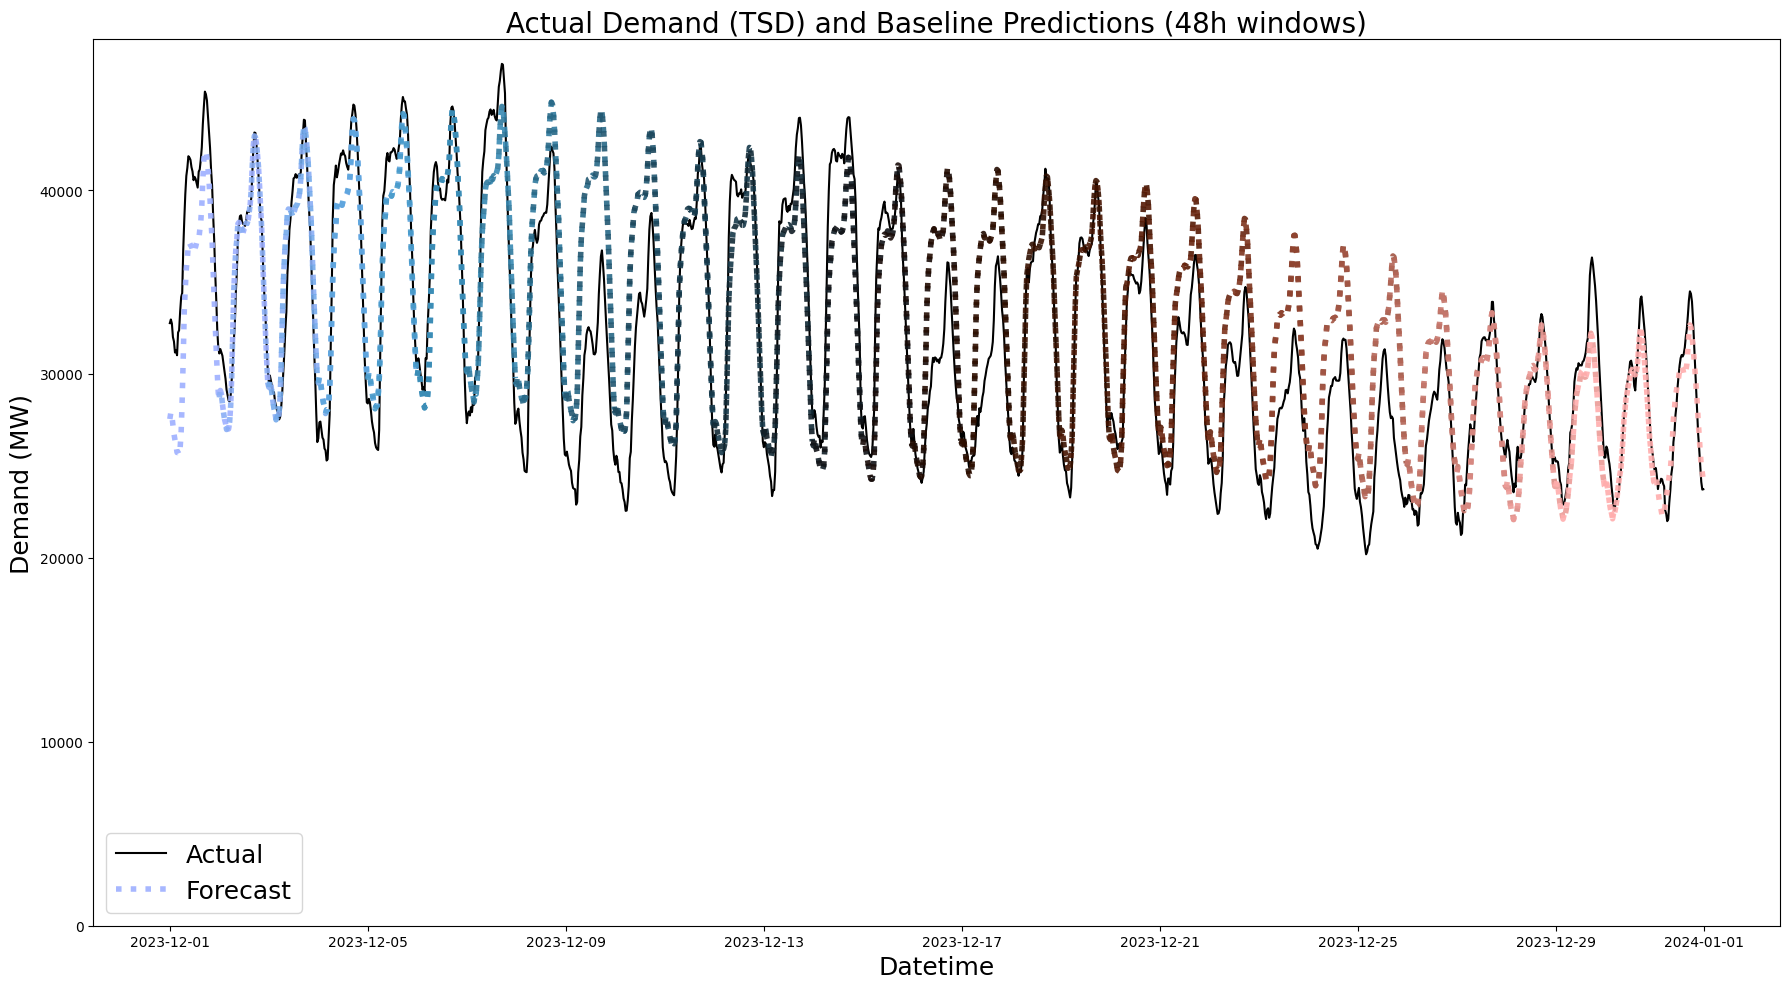

In [15]:
# Vizualize baseline model predictions
results_baseline, first_window_baseline = rolling_window_predictions(
    df_december, test_start, test_end, 48, 24, baseline_predict_func, cmap,
    plot_actual=(actual_future_times, actual_future_tsd),
    plot_title="Actual Demand (TSD) and Baseline Predictions (48h windows)"
)

In [16]:
# Print the scores
results_baseline_pd = pd.DataFrame(results_baseline)
print(f"Mean Test RMSE: {results_baseline_pd['rmse'].mean():.2f} MW")
print(f"Mean Test MAPE: {results_baseline_pd['mape'].mean():.2f}%")

Mean Test RMSE: 2840.05 MW
Mean Test MAPE: 0.08%


**ML models' predictions**

In [17]:
# Prepare features for ML 
df_ml = (
    df.with_columns([
        pl.col("datetime"),
        pl.col("tsd"),
        pl.col("datetime").dt.ordinal_day().alias("day_of_year"),  # 1-366
        pl.col("datetime").dt.weekday().alias("day_of_week"),      # 0=Monday, 6=Sunday
        pl.col("datetime").dt.hour().alias("hour"),                # 0-23
        pl.col("tsd").shift(1).alias("demand_lag_30m"),            # Demand 30 minutes prior
        pl.col("tsd").shift(48).alias("demand_lag_24h"),           # Demand 24 hours prior
    ])
)

In [18]:
# Initialize two instances of GradientBoostingRegressor model
model_3 = GradientBoostingRegressor(
        n_estimators=100, max_depth=5, learning_rate=0.1, validation_fraction=0.2, random_state=7
    )
model_5 = GradientBoostingRegressor(
        n_estimators=100, max_depth=5, learning_rate=0.1, validation_fraction=0.2, random_state=7
    )

# Define features and targets
features_3 = ["day_of_week", "hour", "demand_lag_24h"]
features_5 = ["day_of_year", "day_of_week", "hour", "demand_lag_30m", "demand_lag_24h"]
target = "tsd"

In [19]:
# Prepare feature matrices and target vector
X_3 = df_ml.select(features_3)
X_5 = df_ml.select(features_5)
y = df_ml.select(target)

# Prepare training data
train_mask = (df_ml["datetime"] >= train_start) & (df_ml["datetime"] < test_start)

X_3_train = X_3.filter(train_mask).to_pandas()
X_5_train = X_5.filter(train_mask).to_pandas()
y_train = y.filter(train_mask).to_numpy().ravel()

In [ ]:
# Train both models
model_3.fit(X_3_train, y_train)
model_5.fit(X_5_train, y_train)

In [21]:
# For model_3 (3 features)
def ml_predict_func_3(test_df, times):
    X_test = test_df[features_3].to_pandas()
    return model_3.predict(X_test)

# For model_5 (5 features)
def ml_predict_func_5(test_df, times):
    X_test = test_df[features_5].to_pandas()
    return model_5.predict(X_test)

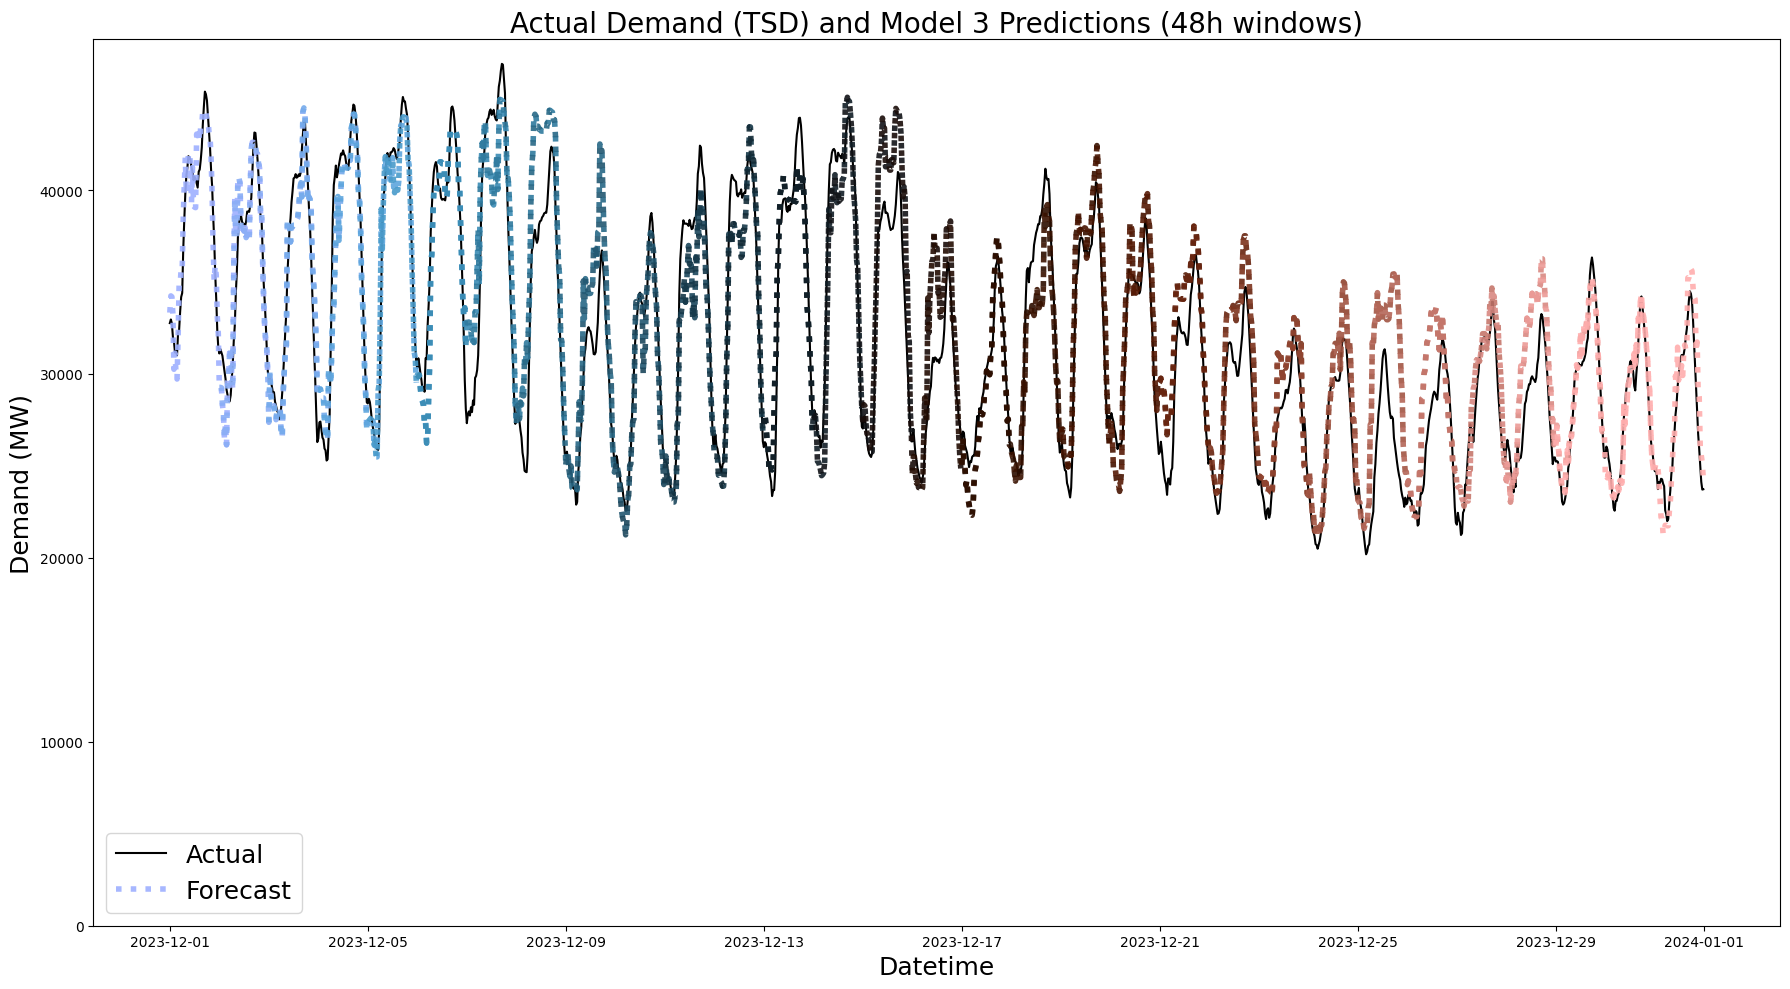

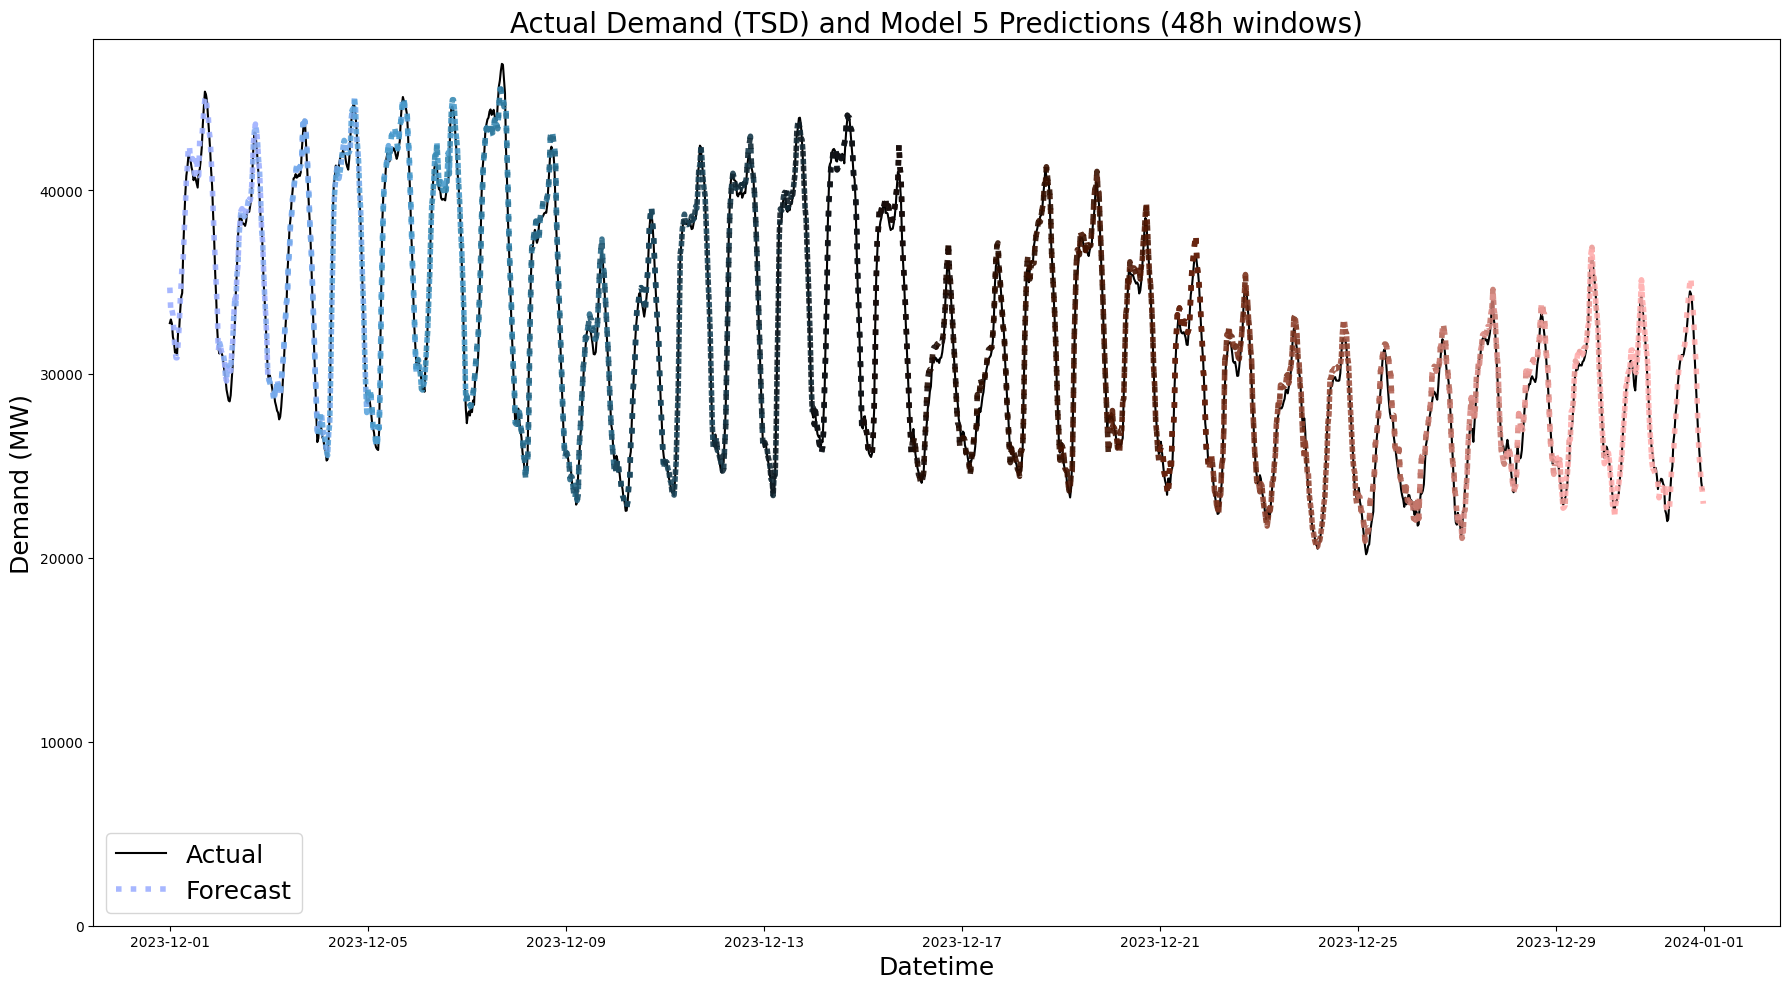

In [22]:
# Run rolling predictions for each model
results_ml_3, first_window_ml_3 = rolling_window_predictions(
    df_ml, test_start, test_end, 48, 24, ml_predict_func_3, cmap,
    plot_actual=(actual_future_times, actual_future_tsd),
    plot_title="Actual Demand (TSD) and Model 3 Predictions (48h windows)"
)

results_ml_5, first_window_ml_5 = rolling_window_predictions(
    df_ml, test_start, test_end, 48, 24, ml_predict_func_5, cmap,
    plot_actual=(actual_future_times, actual_future_tsd),
    plot_title="Actual Demand (TSD) and Model 5 Predictions (48h windows)"
)

In [23]:
# Print the scores for model 3
results_ml_3_pd = pd.DataFrame(results_ml_3)
print(f"Mean Test RMSE: {results_ml_3_pd['rmse'].mean():.2f} MW")
print(f"Mean Test MAPE: {results_ml_3_pd['mape'].mean():.2f}%")

Mean Test RMSE: 2310.59 MW
Mean Test MAPE: 0.06%


In [24]:
# Print the scores for model 5
results_ml_5_pd = pd.DataFrame(results_ml_5)
print(f"Mean Test RMSE: {results_ml_5_pd['rmse'].mean():.2f} MW")
print(f"Mean Test MAPE: {results_ml_5_pd['mape'].mean():.2f}%")

Mean Test RMSE: 657.46 MW
Mean Test MAPE: 0.02%


## Forecast comparison: the first 48h window 

In [25]:
# Prepare data for the first 48h window
actual_times = first_window_baseline["datetime"]
actual_values = df_ml.filter(
    (df_ml["datetime"] >= actual_times.iloc[0]) & (df_ml["datetime"] <= actual_times.iloc[-1])
)["tsd"].to_numpy()

# Forecasts for the first 48h window
baseline_pred = first_window_baseline["prediction"]
gbr_pred = first_window_ml_3["prediction"]
gbr_extra_pred = first_window_ml_5["prediction"]

# Plotly colors (same as in the last block)
color_baseline = '#ff7f0e'
color_gbr = '#bcbd22'
color_gbr_extra = '#2ca02c'

fig = go.Figure()

# Actual (solid black)
fig.add_trace(go.Scatter(
    x=actual_times,
    y=actual_values,
    mode='lines',
    name='Actual',
    line=dict(color='black', width=2, dash='solid')
))

# Baseline forecast (dotted)
fig.add_trace(go.Scatter(
    x=actual_times,
    y=baseline_pred,
    mode='lines+markers',
    name='Baseline: 7-day mean',
    line=dict(color=color_baseline, width=3, dash='dot'),
    marker=dict(color=color_baseline)
))

# GBR 3 features (dotted)
fig.add_trace(go.Scatter(
    x=actual_times,
    y=gbr_pred,
    mode='lines+markers',
    name='GBR (3 features)',
    line=dict(color=color_gbr, width=3, dash='dot'),
    marker=dict(color=color_gbr)
))

# GBR 5 features (dotted)
fig.add_trace(go.Scatter(
    x=actual_times,
    y=gbr_extra_pred,
    mode='lines+markers',
    name='GBR (5 features)',
    line=dict(color=color_gbr_extra, width=3, dash='dot'),
    marker=dict(color=color_gbr_extra)
))

fig.update_layout(
    title="First 48h Window: Actual vs Forecasts",
    xaxis_title="Datetime",
    yaxis_title="Demand (MW)",
    title_font=dict(size=20),
    title_x=0.5,
    plot_bgcolor='whitesmoke',
    legend=dict(font=dict(size=16)),
    width=1100,
    height=500
)

fig.show()

## Forecast comparison: RMSE throught the whole month of December 2023

In [26]:

# Make x axis go from 1 to 31 (all December days)
x_days = list(range(1, 32))

# Prepare y values for each model, filling missing days with None for gaps
def fill_rmse_by_day(results_df):
    rmse_by_day = {d.day: v for d, v in zip(results_df["test_start"], results_df["rmse"])}
    return [rmse_by_day.get(day, None) for day in x_days]

y_7d = fill_rmse_by_day(pd.DataFrame(results_baseline))
y_ml_3 = fill_rmse_by_day(pd.DataFrame(results_ml_3))
y_ml_5 = fill_rmse_by_day(pd.DataFrame(results_ml_5))

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x_days,
    y=y_7d,
    mode='lines+markers',
    name='Baseline: 7-day mean',
    line=dict(color='#ff7f0e')
))
fig.add_trace(go.Scatter(
    x=x_days,
    y=y_ml_3,
    mode='lines+markers',
    name='GBR',
    line=dict(color='#bcbd22')
))
fig.add_trace(go.Scatter(
    x=x_days,
    y=y_ml_5,
    mode='lines+markers',
    name='GBR with extra features',
    line=dict(color='#2ca02c')
))

fig.update_layout(
    title="Comparison of different energy demand forecasting methods for December 2023 in the UK",
    xaxis_title="Day of December",
    yaxis_title="RMSE (MW)",
    plot_bgcolor='whitesmoke',
    legend=dict(
        font=dict(size=18),
        x=1,
        y=1,
        xanchor='right',
        yanchor='top'
    ),
    title_font=dict(size=20),
    title_x=0.5,
    xaxis=dict(
        tickmode='linear',
        tick0=1,
        dtick=1,
        range=[0.1, 31],
        tickfont=dict(size=16),
        title_font=dict(size=18)
    ),
    yaxis=dict(
        range=[0, 6999],
        tickfont=dict(size=16), 
        title_font=dict(size=18)
        ),
    width=1100,
    height=500
)

fig.show()

## Feature Importance

In [27]:
# Test functions for feature importance plot and values
def test_feature_importance_plot(model, features):
    importances = model.feature_importances_
    feature_names = features

    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    sorted_names = [feature_names[i] for i in indices]
    sorted_importances = importances[indices]

    plt.figure(figsize=(8, 5))
    plt.barh(sorted_names, sorted_importances, color='dodgerblue')
    plt.xlabel('Importance')
    plt.title('Feature Importances for GBR (5 features)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Verify normalized importance values
def test_feature_importance_values(model, features):
    importances = model.feature_importances_
    assert len(importances) == len(features)
    assert np.isclose(importances.sum(), 1.0)

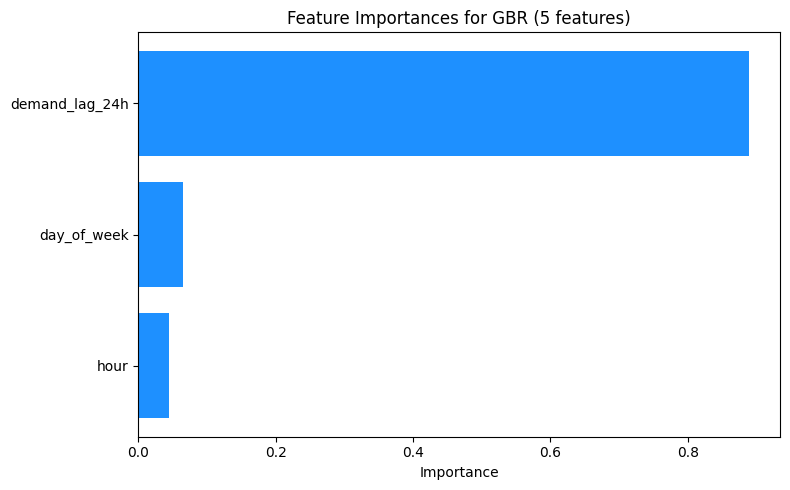

In [28]:
# Feature importance test for model 3
test_feature_importance_plot(model_3, features_3)
test_feature_importance_values(model_3, features_3)

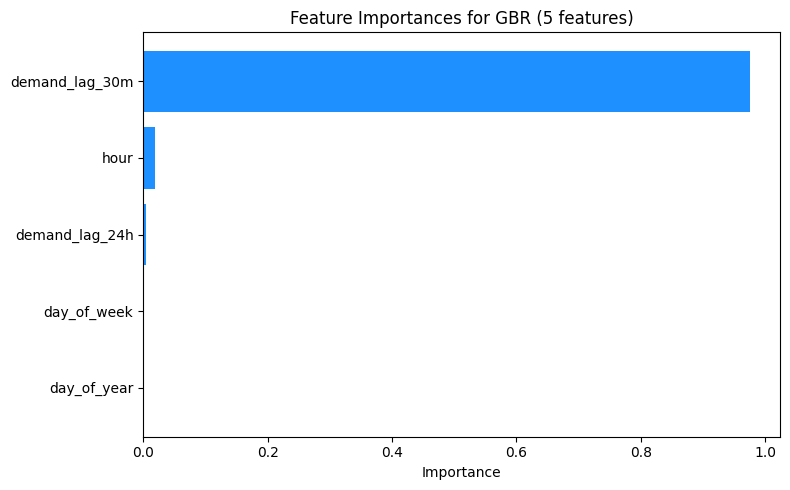

In [29]:
# Feature importance test for model 5
test_feature_importance_plot(model_5, features_5)
test_feature_importance_values(model_5, features_5)

## Conclusions:

**Lagged demand features are the most important**: Including demand_lag_30m (previous 30 min) and to a lesser extend demand_lag_24h (previous day) as features improves the model's ability to forecast demand, as shown by the lower RMSE and MAPE for the GBR models compared to the baseline.

**Temporal features help:** Features like day_of_week, hour, and day_of_year capture seasonality and daily/weekly cycles, which are important for electricity demand forecasting.

**Model performance improves with more features:** The GBR model with 5 features outperforms the one with only 3, indicating that additional temporal and lagged features add predictive value. 

**Baseline is outperformed:** Both GBR models provide better accuracy than the simple 7-day mean baseline, demonstrating the value of machine learning and feature engineering for this task.

## Ways to improve

**Add weather data:** temperature could be useful to predict heating/cooling associated electricity demands.

**Add more lagged features:** 1h, 3h, 12h, 1 week (and explore which ones are most important).

**Tune hyperparameters:** Use grid search or Bayesian optimization to find the best model parameters.

**Handle special cases:** Daylight saving creates duplicate/missing time intances, which could affect forecasting.

**Ensemble methods:** Combine predictions from multiple models to reduce variance and improve accuracy.
